In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """))

# Instance constructor for IVRP

<div class="alert alert-block alert-info">
This notebook simulates instances of the IVRP. 

The code is distributed into two sections. [Section (a)](#(a)-Sample-from-known-graph) creates an instance from an already sampled graph with at most 548 points of interest in the city of Quito. [Section (b)](#(b)-Build-graph) creates instead a multigraph that can be used to sample instances.
</div>

In [1]:
# Packages
import numpy  as np
import igraph    as ig
import osmnx     as ox
import networkx  as nx
import pandas    as pd
import geopandas as gpd

from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt

from shapely.geometry import Point, LineString

In [2]:
print('NumPy: {0}, Pandas: {1}, OSMnx: {2} '.format(np.__version__, pd.__version__, ox.__version__))

NumPy: 1.26.4, Pandas: 2.2.3, OSMnx: 2.0.0 


For walking speed, we use the average walking speed for people in the 30–49 range according to [this study](https://www.healthline.com/health/exercise-fitness/average-walking-speed#average-speed-by-age).

In [3]:
mean_p     = (1.43+1.39)/2                        # Seconds
mean_p    *= 60.0                                 # Minutes

For vehicle travel speed, we use $30$ kilometres per hour.

In [4]:
mean_v    = 30 * 1000/60                         # Minutes

# (a) Sample from known graph

<div class="alert alert-block alert-warning">
In this case, we sample from data that has been already collected:
</div>

Sample size:

In [5]:
sample_size = 90

In [6]:
rng = np.random.default_rng(1993)
η   = min(sample_size, 548)                  # Limit size of dataset

Load data and sample:

In [7]:
# Load graphical network for reference
G_w = ox.convert.graph_from_gdfs(pd.read_pickle('Sampling_Data/UIO_gdf_nodes.pkl'), pd.read_pickle('Sampling_Data/UIO_gdf_edges.pkl'))
G_v = ox.convert.graph_from_gdfs(pd.read_pickle('Sampling_Data/UIO_gdf_nodes_v.pkl'), pd.read_pickle('Sampling_Data/UIO_gdf_edges_v.pkl'))
pois = gpd.read_file('Sampling_Data/PoIs.geojson')

In [8]:
# Node 0 is the depot, so we don't select it as a store
Choice = rng.choice(np.arange(1,pois.index.size), η, replace=False, shuffle=False);    Choice.sort()

In [9]:
Sampled_PoIs = pois.iloc[Choice]

## Pedestrians

Plot (optional)

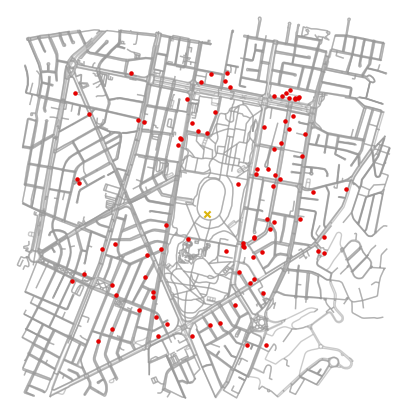

In [10]:
# Plotting pedestrian network
fig, ax = ox.plot_graph(G_w, figsize=(5,10), bgcolor='White', node_color='xkcd:grey blue', edge_alpha=0.5, node_size=0, show=False, close=False)
Sampled_PoIs.plot(ax=ax, color='xkcd:red', marker='o', markersize=5)
plt.scatter(pois.iloc[0].lon, pois.iloc[0].lat, 20, 'xkcd:gold', marker='x')  # This is the depot
plt.show()

In [11]:
Walking_Distance = pd.read_pickle('Sampling_Data/UIO_distances_walk.pkl')

```Python
Walking_Distance[Sampled_PoIs.id].loc[Sampled_PoIs.id].equals(Walking_Distance.iloc[Choice,Choice])
>> True

```

In [12]:
Walk_Sample = Walking_Distance.iloc[Choice,Choice]

In [13]:
t_walker = (1.0/mean_p) * Walk_Sample
t_walker = t_walker.round(2)

In [14]:
t_walker.head()

,346384882,348042041,368134160,429653168,466539441,1123425197,2588673936,2807067554,2807606180,2975095377,...,666107482,666107483,666191548,666191549,666191553,666191554,666191585,666448460,667975765,668140283
346384882,0.00,10.69,0.41,3.79,7.81,1.04,8.45,0.99,3.80,0.17,...,2.12,2.12,2.12,2.12,2.12,2.12,1.80,3.12,1.72,2.12
348042041,10.69,0.00,10.29,7.46,3.68,10.10,2.31,10.60,6.89,10.52,...,10.06,10.06,10.06,10.06,10.06,10.06,9.74,8.46,9.66,10.06
368134160,0.41,10.29,0.00,3.38,7.42,0.65,8.05,0.60,3.40,0.24,...,1.72,1.72,1.72,1.72,1.72,1.72,1.39,2.73,1.32,1.72
429653168,3.79,7.46,3.38,0.00,6.82,4.03,5.22,3.98,1.88,3.62,...,3.16,3.16,3.16,3.16,3.16,3.16,2.83,6.11,2.76,3.16
466539441,7.81,3.68,7.42,6.82,0.00,6.77,2.56,7.27,6.24,7.64,...,9.14,9.14,9.14,9.14,9.14,9.14,8.81,7.67,8.73,9.14


In [15]:
t_walker.to_csv('Instances/Pollster_' + str(η)+'.txt', header=None, index=None, sep=' ', mode='a')

## Vehicles

We add the depot to this dataset:

In [16]:
Choice = np.concatenate([[0],Choice])

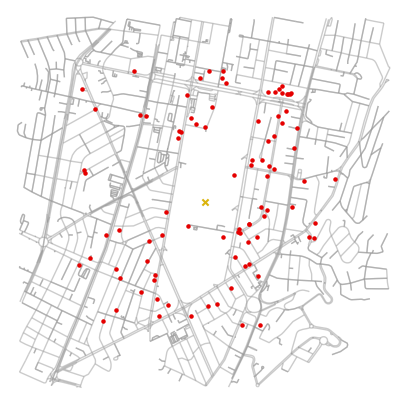

In [17]:
# Plotting vehicular network (without links)
fig, ax = ox.plot_graph(G_v, figsize=(5,10), bgcolor='White', node_color='xkcd:grey blue', edge_alpha=0.5, node_size=0, show=False, close=False)
Sampled_PoIs.plot(ax=ax, color='xkcd:red', marker='o', markersize=5)
plt.scatter(pois.iloc[0].lon, pois.iloc[0].lat, 20, 'xkcd:gold', marker='x')  # This is the depot
plt.show()

In [18]:
Vehicular_Distance = pd.read_pickle('Sampling_Data/UIO_distances_vehicle.pkl')
Vehicular_Sample = Vehicular_Distance.iloc[Choice,Choice]
t_vehicle = (1.0/mean_v) * Vehicular_Sample
t_vehicle = t_vehicle.round(2)
t_vehicle.head()

,346384454,346384882,348042041,368134160,429653168,466539441,1123425197,2588673936,2807067554,2807606180,...,666107482,666107483,666191548,666191549,666191553,666191554,666191585,666448460,667975765,668140283
346384454,0.00,0.64,0.18,0.10,0.11,0.11,0.72,0.46,0.88,0.81,...,2.98,2.94,2.74,2.74,2.27,2.26,2.37,2.37,1.57,2.41
346384882,0.64,0.00,0.45,0.71,0.74,0.72,0.43,0.85,0.41,0.34,...,2.51,2.47,2.27,2.28,1.80,1.79,1.90,1.90,1.10,1.94
348042041,0.18,0.45,0.00,0.26,0.29,0.26,0.72,0.61,0.69,0.62,...,2.80,2.76,2.56,2.56,2.09,2.08,2.18,2.19,1.39,2.22
368134160,0.10,0.71,0.26,0.00,0.03,0.01,0.82,0.56,0.95,0.88,...,3.05,3.02,2.81,2.82,2.35,2.34,2.44,2.45,1.65,2.48
429653168,0.11,0.74,0.29,0.03,0.00,0.02,0.81,0.55,0.98,0.91,...,3.08,3.04,2.84,2.85,2.37,2.36,2.47,2.48,1.68,2.51


In [19]:
t_vehicle.to_csv('Instances/Vehicle_' + str(η)+'.txt', header=None, index=None, sep=' ', mode='a')

In [20]:
print('Aᵥ is not connected.' if np.isinf(t_vehicle).values.any() else 'Aᵥ is a connected network.')

Aᵥ is a connected network.


## Service

In [21]:
Service = pd.DataFrame(rng.integers(1,20,η+1))
Service.at[0,0] = 0
Service.to_csv('Instances/Service_' + str(η)+'.txt', header=None, index=None, sep=' ', mode='a')

---

# (b) Build graph

<div class="alert alert-block alert-warning">
Insert an address, from where we will project the <b>P</b>oints <b>o</b>f <b>I</b>nterest (PoIs).
</div>

In [4]:
address  = 'Parque La Carolina, Quito, Ecuador'    # Depot
distance = 1300                                    # Radius of network

## **Step 1:** Retrieve map data around a named address

In [5]:
geolocator = Nominatim(user_agent="geoapi")
location = geolocator.geocode(address)

if not location:
    raise ValueError(f"Address not found: {address}")

# Create depot at centre
depot = (location.latitude, location.longitude)

# Retrieve the pedestrian graph around the location
G = ox.graph_from_point(depot, dist=distance, network_type='all', simplify=True, truncate_by_edge=False)

# Retrieve the vehicular graph around the location
Gv = ox.graph_from_point(depot, dist=distance+100, network_type='drive_service', simplify=True, truncate_by_edge=False)

In [6]:
G  = G.subgraph(max(nx.strongly_connected_components(G), key=len))
Gv = Gv.subgraph(max(nx.weakly_connected_components(Gv), key=len))

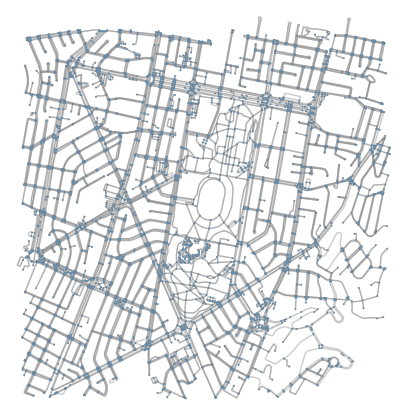

In [7]:
fig, ax = ox.plot_graph(G, figsize=(5,10), bgcolor='White', node_color='xkcd:grey blue', edge_alpha=0.5, node_size=2)

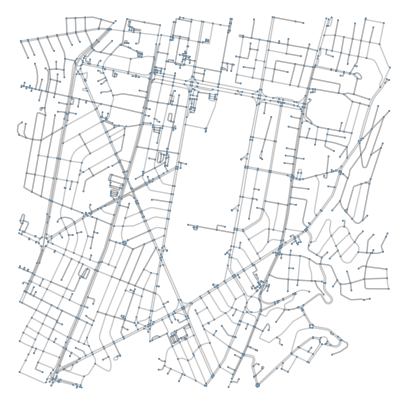

In [8]:
fig, ax = ox.plot_graph(Gv, figsize=(5,10), bgcolor='White', node_color='xkcd:grey blue', edge_alpha=0.5, node_size=2)

The graph is connected for footpaths:

In [9]:
nx.is_connected(G.to_undirected())

True

and weakly connected for vehicles:

In [10]:
nx.is_connected(Gv.to_undirected())

True

## **Step 2:** Identify PoIs

In [11]:
amenities = ['arts_centre','bank','bar','bureau_de_change','cafe','car_rental','car_wash','childcare',
     'cinema','clinic','college','community_centre','conference_centre','courthouse','dentist',
     'doctors','doctors;clinic','embassy','fast_food','fast_food;college','food_court','fuel',
     'hospital','ice_cream','internet_cafe','kindergarten','language_school','marketplace',
     'nursing_home','pharmacy','place_of_worship','police','post_box','post_office','pub',
     'public_building','restaurant','school','shelter','social_facility','studio','veterinary']

# Retrieve POIs within the distance using the address
pois = ox.features_from_address(address, {'amenity':amenities}, dist=1000).iloc[:, 0:5]

In [12]:
pois = pois[pois.amenity.notnull()]
pois['geometry'] = pois['geometry'].representative_point()
pois['lon'] = pois['geometry'].apply(lambda p: p.x)
pois['lat'] = pois['geometry'].apply(lambda p: p.y)
# Remove additional clutter
pois = pois[pois.columns[[0,1,2,3,5,6]]]
pois.head()

geometry  \
element id                                      
node    346384464  POINT (-78.47777 -0.17858)   
        346384882   POINT (-78.4792 -0.17767)   
        348028951  POINT (-78.48479 -0.17675)   
        348042041  POINT (-78.49245 -0.18767)   
        368134160  POINT (-78.48036 -0.18139)   

                                        addr:street      amenity  \
element id                                                         
node    346384464                 Manuel M. Sánchez   restaurant   
        346384882           Avenida Naciones Unidas         bank   
        348028951              Avenida Río Amazonas       cinema   
        348042041                               NaN  arts_centre   
        368134160  Avenida República de El Salvador   restaurant   

                                         name        lon       lat  
element id                                                          
node    346384464            Oh Qué Bueno Más -78.477771 -0.178577  
        346384882                Citi Ecuador -78.479203 -0.177675  
        348028951                  Multicines -78.484794 -0.176749  
        348042041  Centro Artístico Don Bosco -78.492447 -0.187668  
        368134160                  Di Serggio -78.480356 -0.181388

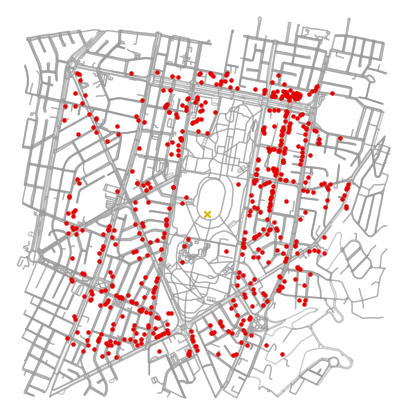

In [13]:
# Pedestrian access
fig, ax = ox.plot_graph(G, figsize=(5,10), bgcolor='White', node_color='xkcd:grey blue', edge_alpha=0.5, node_size=0, show=False, close=False)
pois.plot(ax=ax, color='xkcd:red', marker='o', markersize=5)
plt.scatter(depot[1], depot[0], 20, 'xkcd:gold', marker='x')  # This is the depot
#ox.plot_footprints(pois, figsize=(3, 3), ax=ax)
plt.show()

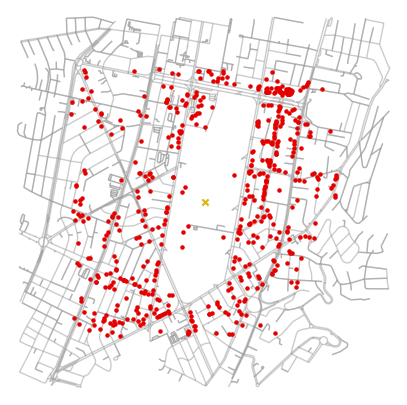

In [14]:
# Vehicular access
fig, ax = ox.plot_graph(Gv, figsize=(5,10), bgcolor='White', node_color='xkcd:grey blue', edge_alpha=0.5, node_size=0, show=False, close=False)
pois.plot(ax=ax, color='xkcd:red', marker='o', markersize=5)
plt.scatter(depot[1], depot[0], 20, 'xkcd:gold', marker='x')  # This is the depot
#ox.plot_footprints(pois, figsize=(3, 3), ax=ax)
plt.show()

We add the centre of the map as a POI. This is going to be our default depot, but this can be changed by the user.

In [15]:
df = pd.DataFrame( [[Point(depot[::-1]), 'Depot St', 'depot', 'Depot',  depot[1], depot[0]]], 
                 columns = pois.columns.values, index = pd.MultiIndex.from_tuples( [ ('node',int(pois.index.min()[1] - 10)) ], names=['element', 'id'] )  )

In [16]:
pois = pd.concat([df, pois])

Find the nearest edge for each POI

In [17]:
pois.head(3)

geometry  \
element id                                                
node    346384454  POINT (-78.48470265056943 -0.183873)   
        346384464        POINT (-78.4777712 -0.1785768)   
        346384882        POINT (-78.4792029 -0.1776747)   

                               addr:street     amenity              name  \
element id                                                                 
node    346384454                 Depot St       depot             Depot   
        346384464        Manuel M. Sánchez  restaurant  Oh Qué Bueno Más   
        346384882  Avenida Naciones Unidas        bank      Citi Ecuador   

                         lon       lat  
element id                              
node    346384454 -78.484703 -0.183873  
        346384464 -78.477771 -0.178577  
        346384882 -78.479203 -0.177675

In [18]:
# Convert to GeoDataFrame
pois = gpd.GeoDataFrame(pois, geometry='geometry')
pois.set_crs(epsg=int(G.graph['crs'][5:]), inplace=True);

In [19]:
display(pois.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
pois['nearest_edge_w'] = ox.nearest_edges(G, pois['lon'].values, pois['lat'].values)
pois['nearest_edge_v'] = ox.nearest_edges(Gv, pois['lon'].values, pois['lat'].values)

In [21]:
pois.head(3)

geometry              addr:street  \
element id                                                               
node    346384454   POINT (-78.4847 -0.18387)                 Depot St   
        346384464  POINT (-78.47777 -0.17858)        Manuel M. Sánchez   
        346384882   POINT (-78.4792 -0.17767)  Avenida Naciones Unidas   

                      amenity              name        lon       lat  \
element id                                                             
node    346384454       depot             Depot -78.484703 -0.183873   
        346384464  restaurant  Oh Qué Bueno Más -78.477771 -0.178577   
        346384882        bank      Citi Ecuador -78.479203 -0.177675   

                                nearest_edge_w                nearest_edge_v  
element id                                                                    
node    346384454   (349909545, 4255648280, 0)  (11173255520, 9755073060, 0)  
        346384464  (9579460412, 9579473435, 0)    (7201823430, 267537531, 0)  
        346384882  (9706306405, 9627569878, 0)   (6236643656, 9627569888, 0)

## Step 3: Add POIs to network as nodes by projecting them onto the nearest edge

In [22]:
G_poi_w = nx.Graph(G)    # Create a copy of the original graph to project to simpler geometry
G_poi_v = nx.Graph(Gv)

In [23]:
for idx, poi in pois.iterrows():

    '''
        Pedestrian
    '''
    edge_u, edge_v, edge_key = poi['nearest_edge_w']

    # Get the edge geometry
    edge_data = G_poi_w[edge_u][edge_v]
    edge_geom = edge_data.get('geometry', 
                              LineString([ (G_poi_w.nodes[edge_u]['x'], G_poi_w.nodes[edge_u]['y']), 
                                           (G_poi_w.nodes[edge_v]['x'], G_poi_w.nodes[edge_v]['y']) ]))

    # Project the POI onto the edge
    projected_point = edge_geom.interpolate(edge_geom.project(poi['geometry']))
    # Add the projected point as a new node
    poi_node_id = f'poi_{idx[1]}'
    G_poi_w.add_node(poi_node_id, x=projected_point.x, y=projected_point.y)

    # Compute distances to edge endpoints
    dist_to_u = projected_point.distance(Point(G_poi_w.nodes[edge_u]['x'], G_poi_w.nodes[edge_u]['y']))
    dist_to_v = projected_point.distance(Point(G_poi_w.nodes[edge_v]['x'], G_poi_w.nodes[edge_v]['y']))

    # Add two-way edges between the new POI node and the original edge endpoints
    G_poi_w.add_edge(edge_u, poi_node_id, weight=dist_to_u, length=dist_to_u)
    G_poi_w.add_edge(poi_node_id, edge_u, weight=dist_to_u, length=dist_to_u)
    G_poi_w.add_edge(edge_v, poi_node_id, weight=dist_to_v, length=dist_to_v)
    G_poi_w.add_edge(poi_node_id, edge_v, weight=dist_to_v, length=dist_to_v)
    
    
    '''
        Vehicular
    '''
    edge_u, edge_v, edge_key = poi['nearest_edge_v']
    
    # Get the edge geometry
    edge_data = G_poi_v[edge_u][edge_v]
    edge_geom = edge_data.get('geometry', 
                              LineString([ (G_poi_v.nodes[edge_u]['x'], G_poi_v.nodes[edge_u]['y']), 
                                           (G_poi_v.nodes[edge_v]['x'], G_poi_v.nodes[edge_v]['y']) ]))

    # Project the POI onto the edge
    projected_point = edge_geom.interpolate(edge_geom.project(poi['geometry']))
    # Add the projected point as a new node
    poi_node_id = f'poi_{idx[1]}'
    G_poi_v.add_node(poi_node_id, x=projected_point.x, y=projected_point.y)

    # Compute distances to edge endpoints
    dist_to_u = projected_point.distance(Point(G_poi_v.nodes[edge_u]['x'], G_poi_v.nodes[edge_u]['y']))
    dist_to_v = projected_point.distance(Point(G_poi_v.nodes[edge_v]['x'], G_poi_v.nodes[edge_v]['y']))

    # Add two-way edges between the new POI node and the original edge endpoints
    G_poi_v.add_edge(edge_u, poi_node_id, weight=dist_to_u, length=dist_to_u)
    G_poi_v.add_edge(poi_node_id, edge_u, weight=dist_to_u, length=dist_to_u)
    G_poi_v.add_edge(edge_v, poi_node_id, weight=dist_to_v, length=dist_to_v)
    G_poi_v.add_edge(poi_node_id, edge_v, weight=dist_to_v, length=dist_to_v)

## Step 4: Compute shortest paths

To compute the network of shortest paths, we switch to `iGraph`, which has optimised routes in `C` for network analysis.

In [24]:
G_n2i_w = nx.relabel.convert_node_labels_to_integers(G_poi_w)
G_n2i_v = nx.relabel.convert_node_labels_to_integers(G_poi_v)

In [25]:
# Pedestrian
G_ig_w = ig.Graph(directed=False)
G_ig_w.add_vertices(list(G_n2i_w.nodes()))
G_ig_w.add_edges(list(G_n2i_w.edges()))
G_ig_w.vs['osmid'] = list(G_poi_w.nodes)
G_ig_w.es['length']  = list(nx.get_edge_attributes(G_n2i_w, 'length').values())

# Vehicular
G_ig_v = ig.Graph(directed=True)
G_ig_v.add_vertices(list(G_n2i_v.nodes()))
G_ig_v.add_edges(list(G_n2i_v.edges()))
G_ig_v.vs['osmid'] = list(G_poi_v.nodes)
G_ig_v.es['length']  = list(nx.get_edge_attributes(G_n2i_v, 'length').values())

Walking distances:

In [26]:
Δ = {v['osmid']: v['name']  for v in G_ig_w.vs() if isinstance(v['osmid'], str)}
Δ_poi_label = [int(a[4:]) for a in list(Δ.keys())]

In [27]:
Walking_Distance = pd.DataFrame(
    G_ig_w.distances(source=Δ.values(), target=Δ.values(), weights='length',  mode = 'all', algorithm = 'dijkstra'),
    columns = Δ_poi_label, index = Δ_poi_label
)

In [28]:
Walking_Distance.head()

,346384454,346384464,346384882,348028951,348042041,368134160,410625413,428699835,429653168,466539441,...,667975764,667975765,667975766,668140283,668140306,668311651,1103431797,1233223560,1286920720,1286921154
346384454,0.000000,478.785111,405.286015,569.353752,608.950815,371.948914,480.393375,347.226433,559.237151,554.108621,...,483.214205,483.214265,483.214355,517.282703,517.283603,489.866763,771.860691,515.039610,774.899869,706.827517
346384464,478.785111,0.000000,88.259343,407.744374,978.194398,107.852650,177.497705,131.559784,394.097615,734.452354,...,219.117941,219.118001,219.118091,253.186440,253.187339,225.770499,589.020790,759.421456,1106.162497,1076.071100
346384882,405.286015,88.259343,0.000000,334.245277,904.695301,34.353553,103.998608,58.060687,320.598518,660.953257,...,145.618844,145.618904,145.618994,179.687343,179.688242,152.271402,515.521693,685.922359,1032.663400,1002.572003
348028951,569.353752,407.744374,334.245277,0.000000,641.591614,299.891724,409.352637,324.615310,91.108595,586.749420,...,246.766564,246.766624,246.766714,280.835063,280.835963,253.419122,782.076316,547.680409,778.543299,739.468316
348042041,608.950815,978.194398,904.695301,641.591614,0.000000,870.341748,979.802661,884.780357,631.475013,311.672494,...,817.216588,817.216649,817.216739,851.285087,851.285987,823.869147,851.436214,272.603484,198.659471,97.876833


Vehicular distances:

In [29]:
Δ = {v['osmid']: v['name']  for v in G_ig_v.vs() if isinstance(v['osmid'], str)}
Δ_poi_label = [int(a[4:]) for a in list(Δ.keys())]

In [30]:
Vehicular_Distance = pd.DataFrame(
    G_ig_w.distances(source=Δ.values(), target=Δ.values(), weights='length',  mode = 'out', algorithm = 'dijkstra'),
    columns = Δ_poi_label, index = Δ_poi_label
)

In [31]:
Vehicular_Distance.head()

,346384454,346384464,346384882,348028951,348042041,368134160,410625413,428699835,429653168,466539441,...,667975764,667975765,667975766,668140283,668140306,668311651,1103431797,1233223560,1286920720,1286921154
346384454,0.000000,19.145056,317.966233,80.131564,91.079622,50.990985,44.647241,49.467519,52.808431,53.967758,...,816.029016,786.642461,1199.514180,1202.702298,1205.474636,1207.967108,1213.021216,1217.164709,1213.788166,1216.403047
346384464,19.145056,0.000000,300.975370,63.337491,74.798793,57.050656,63.394400,68.214678,71.473591,60.459600,...,799.038153,769.651598,1182.523317,1185.711435,1188.483773,1190.976245,1196.030352,1200.173846,1196.797303,1199.412184
346384882,317.966233,300.975370,0.000000,238.347912,226.886611,355.604991,361.948735,366.769013,370.027926,359.013936,...,581.818929,552.432374,965.304093,968.492211,971.264549,973.757021,978.811129,982.954622,979.578079,982.192960
348028951,80.131564,63.337491,238.347912,0.000000,11.461302,117.770322,124.114066,128.934344,132.193257,121.179266,...,736.410696,707.024141,1119.895860,1123.083978,1125.856315,1128.348788,1133.402895,1137.546388,1134.169846,1136.784727
348042041,91.079622,74.798793,226.886611,11.461302,0.000000,128.718380,135.062125,139.882402,143.141315,132.127325,...,724.949394,695.562839,1108.434558,1111.622676,1114.395013,1116.887486,1121.941593,1126.085087,1122.708544,1125.323425


## Store shortest distances, times, and graphs:

* Distances

In [32]:
Walking_Distance.to_pickle('Sampling_Data/UIO_distances_walk.pkl')
Vehicular_Distance.to_pickle('Sampling_Data/UIO_distances_vehicle.pkl')

* Times

In [33]:
t_walker = (1.0/mean_p) * Walking_Distance
t_walker = t_walker.round(2)

In [34]:
t_walker.to_csv('Sampling_Data/UIO_walk_times.txt', header=None, index=None, sep=' ', mode='a')

In [35]:
t_walker.head()

,346384454,346384464,346384882,348028951,348042041,368134160,410625413,428699835,429653168,466539441,...,667975764,667975765,667975766,668140283,668140306,668311651,1103431797,1233223560,1286920720,1286921154
346384454,0.00,5.66,4.79,6.73,7.20,4.40,5.68,4.10,6.61,6.55,...,5.71,5.71,5.71,6.11,6.11,5.79,9.12,6.09,9.16,8.35
346384464,5.66,0.00,1.04,4.82,11.56,1.27,2.10,1.56,4.66,8.68,...,2.59,2.59,2.59,2.99,2.99,2.67,6.96,8.98,13.08,12.72
346384882,4.79,1.04,0.00,3.95,10.69,0.41,1.23,0.69,3.79,7.81,...,1.72,1.72,1.72,2.12,2.12,1.80,6.09,8.11,12.21,11.85
348028951,6.73,4.82,3.95,0.00,7.58,3.54,4.84,3.84,1.08,6.94,...,2.92,2.92,2.92,3.32,3.32,3.00,9.24,6.47,9.20,8.74
348042041,7.20,11.56,10.69,7.58,0.00,10.29,11.58,10.46,7.46,3.68,...,9.66,9.66,9.66,10.06,10.06,9.74,10.06,3.22,2.35,1.16


In [37]:
t_vehicle = (1.0/mean_v) * Vehicular_Distance
t_vehicle = t_vehicle.round(2)

In [38]:
t_vehicle.to_csv('Sampling_Data/UIO_vehicle_times.txt', header=None, index=None, sep=' ', mode='a')

In [39]:
t_vehicle.head()

,346384454,346384464,346384882,348028951,348042041,368134160,410625413,428699835,429653168,466539441,...,667975764,667975765,667975766,668140283,668140306,668311651,1103431797,1233223560,1286920720,1286921154
346384454,0.00,0.04,0.64,0.16,0.18,0.10,0.09,0.10,0.11,0.11,...,1.63,1.57,2.40,2.41,2.41,2.42,2.43,2.43,2.43,2.43
346384464,0.04,0.00,0.60,0.13,0.15,0.11,0.13,0.14,0.14,0.12,...,1.60,1.54,2.37,2.37,2.38,2.38,2.39,2.40,2.39,2.40
346384882,0.64,0.60,0.00,0.48,0.45,0.71,0.72,0.73,0.74,0.72,...,1.16,1.10,1.93,1.94,1.94,1.95,1.96,1.97,1.96,1.96
348028951,0.16,0.13,0.48,0.00,0.02,0.24,0.25,0.26,0.26,0.24,...,1.47,1.41,2.24,2.25,2.25,2.26,2.27,2.28,2.27,2.27
348042041,0.18,0.15,0.45,0.02,0.00,0.26,0.27,0.28,0.29,0.26,...,1.45,1.39,2.22,2.22,2.23,2.23,2.24,2.25,2.25,2.25


* Graphs and additional data

In [40]:
gdf = ox.convert.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

In [41]:
gdf[0].to_pickle('Sampling_Data/UIO_gdf_nodes.pkl');    gdf[1].to_pickle('Sampling_Data/UIO_gdf_edges.pkl')
# G = ox.convert.graph_from_gdfs(pd.read_pickle('Sampling_Data/UIO_gdf_nodes.pkl'), pd.read_pickle('Sampling_Data/UIO_gdf_edges.pkl'))

In [45]:
gdf = ox.convert.graph_to_gdfs(Gv, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
gdf[0].to_pickle('Sampling_Data/UIO_gdf_nodes_v.pkl');    gdf[1].to_pickle('Sampling_Data/UIO_gdf_edges_v.pkl')

In [42]:
nx.write_gpickle(G_poi_w, 'Sampling_Data/UIO_GW_n_POIs_walk.json')
nx.write_gpickle(G_poi_v, 'Sampling_Data/UIO_GW_n_POIs_vehicle.json')
#G_poi_w = nx.read_gpickle('Sampling_Data/UIO_GW_n_POIs.json')

In [43]:
pois.to_file('Sampling_Data/PoIs.geojson', driver='GeoJSON')
# gpd.read_file('Sampling_Data/PoIs.geojson')

---

#